# Hierarchical Parity Model

This notebook is used to calculate quantities of interest for the hierarchical parity model.

In [1]:
## imports
import time
import scipy
from scipy.stats import sem
import pandas as pd
import os
from collections import Counter
import seaborn as sns
import numpy as onp #o for "old" or "original"
import jax.numpy as np
import jax
from jax import grad, jit, lax, random, ops, vmap, jacfwd, jacrev, device_get, device_put
from jax.scipy.special import logsumexp
from jax.lib import xla_bridge
from tqdm.notebook import tqdm
#jax.local_devices()
import utils

rng = onp.random.default_rng(12345)

jax version 0.3.7
jax backend gpu


In [2]:
## matplotlib settings
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.style.use('ggplot')

plt.rcParams['font.size'] = '14'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Computer Modern']

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["axes.edgecolor"] = "black"

plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['xtick.major.size'] = 15
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 15
plt.rcParams['ytick.major.width'] = 1

plt.rcParams['xtick.minor.size'] = 7
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 7
plt.rcParams['ytick.minor.width'] = 1
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

abcs = ['(a)', '(b)', '(c)', '(d)']

In [3]:
## create a data directory if one does not already exist
if not os.path.exists('data'):
    os.mkdir('data')

## Degeneracy

Numerically verify the degeneracy of the model. First, let's example the ground state (gs) degeneracy of the uniform model. The gs degeneracy of the uniform model with ferromagnetic couplings $(J>0)$ is trivial: there is always a unique ground state. However, there is an extensive gs degeneracy for the uniform model with anti-ferromagnetic couplings that obeys an interesting recursion relation.

In [4]:
## there is a unique gs for the ferromagnetic case
utils.compute_uniform_gs_degen(4, 1)

(-31, 1)

In [5]:
## the gs degeneracy obeys an interesting pattern for the anti-ferromagnetic case
for k in range(5):
    print('k = %i' %k)
    print('gs energy (total)', utils.compute_uniform_gs_degen(k, -1))
    print('gs energy (parity = 1)', utils.compute_uniform_gs_degen(k, -1, parity=1))
    print('gs energy (parity = -1)', utils.compute_uniform_gs_degen(k, -1, parity=-1))
    print('\n')

k = 0
gs energy (total) (-1, 1)
gs energy (parity = 1) (1, 1)
gs energy (parity = -1) (-1, 1)


k = 1
gs energy (total) (-1, 3)
gs energy (parity = 1) (-1, 1)
gs energy (parity = -1) (-1, 2)


k = 2
gs energy (total) (-3, 4)
gs energy (parity = 1) (-1, 5)
gs energy (parity = -1) (-3, 4)


k = 3
gs energy (total) (-5, 56)
gs energy (parity = 1) (-5, 16)
gs energy (parity = -1) (-5, 40)


k = 4
gs energy (total) (-11, 1280)
gs energy (parity = 1) (-9, 1856)
gs energy (parity = -1) (-11, 1280)




We can derive recursion relatiosn that explain the above pattern. Let $N = 2^k$, with $k=0,1,...$. Also let $d_k$ be the ground state degeneracy, and $d_k^{\pm}$ the degeneracy of the lowest energy states with parity = $+1$ or $-1$. Note that the lowest energy state of a given parity may or may not be a ground state. 

For $N = 1$, $k=0$, the degeneracies are all 1 as there is just a single state. Then the recursion relations are:

$$ 
d_{k}^- = 2 d_{k-1}^- d_{k-1}^+ \, \qquad d_k^+ = \begin{cases} (d_{k-1}^-)^2 & k \text{ odd} \\ (d_{k-1}^-)^2 + (d_{k-1}^+)^2 & k \text{ even} \end{cases} 
$$

From this the full degenaracy can be worked out. For $k$ even only the negative parity lowest energy states are actual ground states, whereas for $k$ odd both sets of states are ground states. So,

$$ 
d_k = \begin{cases} d_k^- + d_k^+ & k \text{ odd} \\ d_k^- & k \text{ even} \end{cases}
$$

In [6]:
def degeneracy(n):
    '''
    Implements the recursion relations for the gs degeneracies of the 
    anti-ferromagnetic uniform model for levels k = 0, ..., n.
    '''
    dplus = {0: 1.0}
    dminus = {0: 1.0}
    dfull = {0: 1.0}
    for k in range(1,n+1):
        dminus[k] = 2 * dminus[k-1] * dplus[k-1]
        if k % 2 == 0:
            dplus[k] = dminus[k-1]**2 + dplus[k-1]**2
            dfull[k] = dminus[k] 
        else:
            dplus[k] = dminus[k-1]**2
            dfull[k] = dminus[k] + dplus[k]
    return {'minus':dminus, 'plus':dplus, 'full':dfull}

The degeneracy grows so fast that numerical overflow is reached very quickly. Therefore, it will be convenient to implement the recursion relations in terms of the log degeneracy.

In [7]:
def log_degeneracy(n):
    '''
    Implements the recursion relations for the gs degeneracies of the 
    anti-ferromagnetic uniform model for levels k = 0, ..., n.
    '''
    gplus = {0: 0.0}
    gminus = {0: 0.0}
    gfull = {0: 0.0}
    for k in range(1,n+1):
        gminus[k] = 1 + gminus[k-1] + gplus[k-1]
        if k % 2 == 0:
            gplus[k] = 2*gminus[k-1] + onp.log(1 + 2**(2*(gplus[k-1]-gminus[k-1])))/onp.log(2)
            gfull[k] = gminus[k] 
        else:
            gplus[k] = 2*gminus[k-1]
            gfull[k] = gminus[k] + onp.log(1 + 2**(gplus[k]-gminus[k]))/onp.log(2)
    return {'minus':gminus, 'plus':gplus, 'full':gfull}

In [8]:
## check
n = 6
deg = degeneracy(n)
log_deg = log_degeneracy(n)

for s in ['minus', 'plus', 'full']:
    print('Check degeneracy type %s: %r' %(s, onp.allclose(onp.log(onp.asarray(list(deg[s].values())))/onp.log(2), onp.asarray(list(log_deg[s].values())))))

Check degeneracy type minus: True
Check degeneracy type plus: True
Check degeneracy type full: True


The degeneracy grows exponentially in $N$: $d_k \sim c^N$, with $c \approx 1.62$.

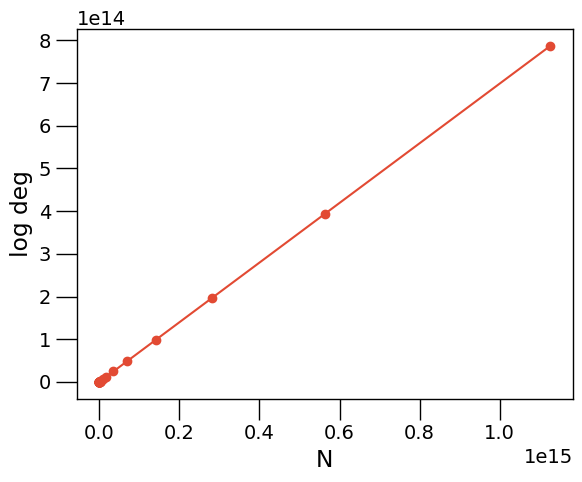

In [9]:
n = 50
log_deg = log_degeneracy(n)

Nvalues = 2.0**onp.asarray(list(log_deg['minus'].keys()))
log_deg_values = onp.asarray(list(log_deg['full'].values()))

fig, ax = plt.subplots()
ax.plot(Nvalues, log_deg_values, '-o')
ax.set_xlabel('N')
ax.set_ylabel('log deg')
#ax.set_yscale('log')
#ax.minorticks_on()
#ax.yaxis.get_ticklocs(minor=True)
#ax.minorticks_on()
## tricky to get minor axes on y axis because of log scale

plt.show()

In [10]:
## do a linear fit
m, b = onp.polyfit(Nvalues[5:], log_deg_values[5:], 1)
m, b

(0.6990153150118494, -0.3871471904703532)

In [11]:
## the c constant in d \sim c^N
2**m

1.6233963951205137

It will also be useful to be able to compute the spectrum for a system of arbitrary couplings. This can be used to verify that a spin system at level $n$ with no single-spin couplings is equivalent to a spin system at level $n-1$ with a $2^{2^{n-1}}$-fold degeneracy for each state.

In [15]:
## n = 3 case
n = 3
N = 2**n
leaf_indices = [3,4,6,7,10,11,13,14]

couplings_large = rng.integers(low=-100000, high=100000, size=2*N-1)
couplings_large = onp.asarray([(i not in leaf_indices)*couplings_large[i] for i in range(len(couplings_large))])
couplings_small = onp.asarray([c for c in couplings_large if c!=0])


spec_large = utils.compute_spectrum(couplings_large)
spec_small = utils.compute_spectrum(couplings_small)

print('Do the sets of unique energies agree: %r' %(spec_large.keys() == spec_small.keys()))
print('Are the degeneracies all 2^(N/2)=%i? Deg = : ' %2**(N/2), (list(spec_large.values())))


Do the sets of unique energies agree: True
Are the degeneracies all 2^(N/2)=16? Deg = :  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]


In [16]:
## n = 4 case
n = 4
N = 2**n
leaf_indices = [4,5,7,8,11,12,14,15,19,20,22,23,26,27,29,30]

couplings_large = rng.integers(low=-100000, high=100000, size=2*N-1)
couplings_large = onp.asarray([(i not in leaf_indices)*couplings_large[i] for i in range(len(couplings_large))])
couplings_small = onp.asarray([c for c in couplings_large if c!=0])


spec_large = utils.compute_spectrum(couplings_large)
spec_small = utils.compute_spectrum(couplings_small)

print('Do the sets of unique energies agree: %r' %(spec_large.keys() == spec_small.keys()))
print('Are the degeneracies all 2^(N/2)=%i? Deg = : ' %2**(N/2), (list(spec_large.values())))

Do the sets of unique energies agree: True
Are the degeneracies all 2^(N/2)=256? Deg = :  [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,

## Dictionary-Based (Non-Auto-Diff) Code

This code is based on using dictionaries, it's much faster than than the Jax code but doesn't allow for derivatives to be computed. 

In [ ]:
n = 12
print('N = %i spins' %(2**n))
beta = 2.0

Use the recursion relations to exactly compute the expectation of the parity operators, $\langle P_{k,p} \rangle$, for a range of temperatures. 

In [ ]:
couplings = utils.generate_couplings_dic(n)
th_beta_list = np.flip(np.linspace(0.1, 0.9, 5))

fig, ax = plt.subplots(1, 2, figsize=(2*11,9))
for i in range(len(th_beta_list)):
    beta = np.arctanh(th_beta_list[i])
    parities = utils.find_parities_dic(beta, couplings)
    
    #ax[0].hist(list(parities.values()), bins=100, label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i])
    sns.kdeplot(list(parities.values()), label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax[0], bw_adjust=.1)
    #sns.histplot(list(parities.values()), color=colors[i], label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax[0])
    ax[0].legend()
    ax[0].set_title(r"Distribution of $\langle P_{k,p} \rangle$")
    ax[0].set_xlabel(r'$\langle P_{k,p} \rangle$')
    ax[1].set_ylabel('Density')
    
    sns.kdeplot(list(parities.values()), label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax[1], bw_adjust=.1, cumulative=True)
    #ax[1].legend()
    ax[1].set_title(r"Cumulative Distribution of $\langle P_{k,p} \rangle$")
    ax[1].set_xlabel(r'$\langle P_{k,p} \rangle$')
    ax[1].set_ylabel('Cumulative Density')
    
plt.savefig('figures/disordered_model_parity_distribution.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Jax Auto-Diff Code

This section uses Jax's autodiff capability to compute quantities expressible as derivatives of the partition function (such as the energy, entropy, or heat capacity).

### Thermodynamic Limit

Inspect convergence as thermodynamic limit is approached

In [ ]:
n_disorder = 100
n_list = [i for i in range(3,10)]

th_beta_list = np.linspace(0.05, 0.95, 20)
sigma = 0.0
prob = 0.5

if os.path.exists('data/f_list_sizescan.npy'):
    print('data already exists, loading')
    f_list = np.load('data/f_list_sizescan.npy')
    e_list = np.load('data/e_list_sizescan.npy')
    s_list = np.load('data/s_list_sizescan.npy')
    c_list = np.load('data/c_list_sizescan.npy')

else:    
    print('data does not already exist, processing')    
    f_list = onp.zeros((len(n_list), n_disorder, len(th_beta_list)))
    e_list = onp.zeros((len(n_list), n_disorder, len(th_beta_list)))
    s_list = onp.zeros((len(n_list), n_disorder, len(th_beta_list)))
    c_list = onp.zeros((len(n_list), n_disorder, len(th_beta_list)))
    #chi_list = onp.zeros((len(n_list), n_disorder, len(th_beta_list)))

    ## loop over different system sizes
    for i_n in range(len(n_list)):
        n = n_list[i_n]
        N = 2**n
        print('processing n = %i' %n)

        ## loop over disorder replicas
        for i in range(n_disorder):
            couplings = utils.generate_couplings(n, prob=prob, sigma=sigma)

            ## loop over temperatures
            for j in range(len(th_beta_list)):
                beta = np.arctanh(th_beta_list[j])

                f_list[i_n, i, j] = utils.free_energy(beta, couplings).item()/N
                e_list[i_n, i, j] = utils.energy(beta, couplings).item()/N
                s_list[i_n, i, j] = utils.entropy(beta, couplings).item()/N
                c_list[i_n, i, j] = utils.heat_capacity(beta, couplings).item()/N
                #chi_list[i_n, i, j] = utils.chi_SG(beta, couplings).item()
                
    ## save the results
    np.save('data/f_list_sizescan.npy', f_list)
    np.save('data/e_list_sizescan.npy', e_list)
    np.save('data/s_list_sizescan.npy', s_list)
    np.save('data/c_list_sizescan.npy', c_list)

Plot the change in a thermodynamic quantity as a function of temperature as $n$ is increased by 1 (i.e., as the system size doubles).

In [ ]:
for i_n in range(len(n_list)-1):
    plt.plot(th_beta_list, (np.mean(f_list, axis=1)[i_n+1] - np.mean(f_list, axis=1)[i_n])/np.mean(f_list, axis=1)[i_n], 
             label=r'$\epsilon_{%i,%i}$' %(i_n+1,i_n))
    plt.xlabel(r'$\tanh(\beta)$')
    plt.title('Free Energy density')
    plt.legend()
plt.show()

In [ ]:
for i_n in range(len(n_list)-1):
    plt.plot(th_beta_list, (np.mean(c_list, axis=1)[i_n+1] - np.mean(c_list, axis=1)[i_n])/np.mean(c_list, axis=1)[i_n], 
             label=r'$\epsilon_{%i,%i}$' %(i_n+1,i_n))
    plt.xlabel(r'$\tanh(\beta)$')
    plt.title('Heat Capacity density')
    plt.legend()   
plt.show()

Overlay curves for multiple system sizes to inspect convergence as $n \rightarrow \infty$:

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(2*11,2*9))
ax = ax.flatten()

## free energy
for i_n in range(len(n_list)):
    #ax[0].plot(th_beta_list, np.mean(f_list[i_n], axis=0), label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
    ax[0].errorbar(th_beta_list, np.mean(f_list[i_n], axis=0), 1.96*sem(f_list[i_n], axis=0), fmt='--o', \
                   label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
ax[0].set_xlabel(r'$\tanh(\beta)$')
ax[0].set_title(r'Free Energy Density $F/N$')
#ax[0].set_ylabel(r'$f$')
ax[0].legend()

## energy
for i_n in range(len(n_list)):
    #ax[1].plot(th_beta_list, np.mean(e_list[i_n], axis=0), label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
    ax[1].errorbar(th_beta_list, np.mean(e_list[i_n], axis=0), 1.96*sem(e_list[i_n], axis=0), fmt='--o', \
                   label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))    
ax[1].set_xlabel(r'$\tanh(\beta)$')
ax[1].set_title(r'Energy Density $\langle E\rangle/N$')
#ax[1].set_ylabel(r'$f$')
#ax[1].legend()

## entropy
for i_n in range(len(n_list)):
#    ax[2].plot(th_beta_list, np.mean(s_list[i_n], axis=0), label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
    ax[2].errorbar(th_beta_list, np.mean(s_list[i_n], axis=0), 1.96*sem(s_list[i_n], axis=0), fmt='--o', \
                   label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))    
ax[2].set_xlabel(r'$\tanh(\beta)$')
ax[2].set_title(r'Entropy Density $S/N$')
#ax[1].legend()

for i_n in range(len(n_list)):
#    ax[3].plot(th_beta_list, np.mean(c_list[i_n], axis=0), label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
    ax[3].errorbar(th_beta_list, np.mean(c_list[i_n], axis=0), 1.96*sem(c_list[i_n], axis=0), fmt='--o', \
                   label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))   
ax[3].set_xlabel(r'$\tanh(\beta)$')
ax[3].set_title(r'Heat Capacity Density $C/N$')

'''
for i_n in range(len(n_list)):
    ax[4].errorbar(th_beta_list, np.mean(chi_list[i_n], axis=0), 1.96*sem(chi_list[i_n], axis=0), fmt='--o', \
                   label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))   
ax[4].set_xlabel(r'$\tanh(\beta)$')
ax[4].set_title(r'$\chi_{SG}$')
'''

## make sure the x tick marks extend to 1.0
for i in range(len(ax)):
    ax[i].xaxis.set_ticks(np.arange(0, 1.2, 0.2))

plt.savefig('figures/disordered_model_thermodynamics.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

### Scan over disorder parameter space $(\sigma, p)$

In [ ]:
def process_data(data, sigma=1):
    x = []
    y = []
    z = []
    
    ## perform the disorder average
    data = np.mean(data, axis=0)

    ## perform gaussian smoothing to make nicer plots
    ## the motivation for this came from this SE post: 
    ## https://stackoverflow.com/questions/12274529/how-to-smooth-matplotlib-contour-plot
    data = scipy.ndimage.gaussian_filter(data, sigma)
    
    ## extract each individual point and add it to a list
    for j in range(len(prob_list)):
        for i in range(len(th_beta_list)):
            x.append(th_beta_list[i])
            y.append(prob_list[j])
            z.append(data[i,j])
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    return x, y, z

In [ ]:
n_grid = 100
n_disorder = 100
n = 9
sigma = 0.0

prob_list = np.linspace(0.05, 0.95, n_grid)
th_beta_list = np.linspace(0.05, 0.95, n_grid)

if os.path.exists('data/f_list_paramscan_n_%i.npy' %n):
    print('data already exists, loading system size: N = %i, state space size = %.2e' % (2**n, 2**(2**n)))
    f_list = np.load('data/f_list_paramscan_n_%i.npy' %n)
    e_list = np.load('data/e_list_paramscan_n_%i.npy' %n)
    s_list = np.load('data/s_list_paramscan_n_%i.npy' %n)
    c_list = np.load('data/c_list_paramscan_n_%i.npy' %n)

else:
    print('data does not already exist, processing system size: N = %i, state space size = %.2e' % (2**n, 2**(2**n)))
    f_list = onp.zeros((n_disorder, len(th_beta_list), len(prob_list)))
    e_list = onp.zeros((n_disorder, len(th_beta_list), len(prob_list)))
    s_list = onp.zeros((n_disorder, len(th_beta_list), len(prob_list)))
    c_list = onp.zeros((n_disorder, len(th_beta_list), len(prob_list)))

    ## loop over p values
    counter = 0
    t = time.time()
    for i_p in tqdm(range(len(prob_list))):
        prob = prob_list[i_p]

        ## loop over disorder replicas
        for k in range(n_disorder):
            couplings = utils.generate_couplings(n, prob=prob, sigma=sigma)

            ## loop over temperatures
            for i_T in range(len(th_beta_list)):
                beta = np.arctanh(th_beta_list[i_T])

                f_list[k, i_T, i_p] = utils.free_energy(beta, couplings).item()/2**n
                e_list[k, i_T, i_p] = utils.energy(beta, couplings).item()/2**n
                s_list[k, i_T, i_p] = utils.entropy(beta, couplings).item()/2**n
                c_list[k, i_T, i_p] = utils.heat_capacity(beta, couplings).item()/2**n

        #print('iter %i/%i | time elapsed = %.2f s | prob = %.2f' %(counter, len(prob_list), time.time() - t, prob))
        counter += 1
        t = time.time()

    ## save the results
    np.save('data/f_list_paramscan_n_%i.npy' %n, f_list)
    np.save('data/e_list_paramscan_n_%i.npy' %n, e_list)
    np.save('data/s_list_paramscan_n_%i.npy' %n, s_list)
    np.save('data/c_list_paramscan_n_%i.npy' %n, c_list)

process the data by making mesh grids:

In [ ]:
data_list = [f_list, e_list, s_list, c_list]
title_list = ['Free Energy density', 'Energy density', 'Entropy density', 'Heat Capacity density']

## process the data
z_list = []
zi_list = []
for i in range(4):
    ## grab the data and arrange it into lists
    x, y, z = process_data(data_list[i], sigma=2)
    z_list.append(z)
    
    ## set up a regular grid of interpolation points    
    ## use the same grid for all thermodynamic quantities
    if i == 0:
        ## original grid
        #xi = x.reshape((n_grid, n_grid))
        #yi = y.reshape((n_grid, n_grid))
        
        ## interpolated grid (smoother)
        n_grid2 = 20
        xi, yi = np.linspace(x.min(), x.max(), n_grid2), np.linspace(y.min(), y.max(), n_grid2)
        xi, yi = np.meshgrid(xi, yi)

    zi = scipy.interpolate.Rbf(x, y, z, function='linear')(xi, yi)
    #zi = z.reshape((n_grid, n_grid))
    zi_list.append(zi)

Make 3d surface plots:

In [ ]:
#cmap options
#['viridis', 'plasma', 'inferno', 'magma', 'cividis']

fig, ax = plt.subplots(2, 2, figsize=(2*11,2*9), subplot_kw=dict(projection='3d'))
ax = ax.flatten()
for i in range(4):
    
    ## grid/axis lines
    #ax[i].w_xaxis.gridlines.set_lw(3.0)
    #ax[i].w_yaxis.gridlines.set_lw(3.0)
    #ax[i].w_zaxis.gridlines.set_lw(3.0)
    #ax[i].w_xaxis.pane.set_color('black');
    #ax[i].w_yaxis.pane.set_color('black');
    #ax[i].w_zaxis.pane.set_color('black');
    #ax[i].w_xaxis.line.set_color('black');
    ax[i].xaxis._axinfo["grid"].update({"linewidth":0.5, 'color':'black'})
    ax[i].yaxis._axinfo["grid"].update({"linewidth":0.5, 'color':'black'})
    ax[i].zaxis._axinfo["grid"].update({"linewidth":0.5, 'color':'black'})

    ## plotting
    #ax.plot_surface(xi, yi, zi)
    #ax.contour3D(xi, yi, zi, 50, cmap='binary')
    ax[i].plot_surface(xi, yi, zi_list[i], rstride=1, cstride=1, cmap='cividis', edgecolor='black')
    #ax[i].plot_wireframe(xi, yi, zi_list[i], color='black', linewidth=0.5)
    ax[i].set_xlabel(r'$\tanh(\beta J)$', labelpad=10)
    ax[i].set_ylabel(r'$p$', labelpad=10)
    ax[i].set_title(title_list[i])    
    #ax[i].text(0.05, 0.975, s=abcs[i], size=24)
    #ax[i].text2D(0.05, 0.95, "2D Text")
plt.tight_layout()
plt.savefig('figures/disordered_model_thermodynamic_surfaceplots.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Make 2d contour plots:

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(2*9,2*9))
ax = ax.flatten()

for i in range(4):
    ax[i].imshow(zi_list[i], 
                 vmin=zi_list[i].min(), 
                 vmax=zi_list[i].max(), 
                 origin='lower', 
                 extent=[x.min(), x.max(), y.min(), y.max()], 
                 interpolation='spline16',
                 cmap='cividis')
    #ax[i].scatter(x, y, c=z_list[i], s=20)    
    contours = ax[i].contour(xi, yi, zi_list[i], 15, linestyles='-', colors='black')
    ax[i].clabel(contours, inline=True, fontsize=12)
    ax[i].set_xlabel(r'$\tanh(\beta J)$')
    ax[i].set_ylabel(r'$p$')
    ax[i].set_title(title_list[i])
    ax[i].grid(visible=None)
    ax[i].text(0.05, 0.975, abcs[i], size=24)
#plt.colorbar()
plt.tight_layout()
plt.savefig('figures/disordered_model_thermodynamic_contourplots.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

### Spin-glass susceptibility

The spin-glass susceptibility is defined as

$$\chi_{SG} = \frac{\beta^2}{N} \sum_{ij} \left[ \langle s_i s_j \rangle - \langle s_i \rangle \langle s_j \rangle \right]^2 \,. $$

According to Mezard and Montanari, the finiteness of $\chi_{SG}$ as $N \rightarrow \infty$ is a necessary (but not always sufficient) condition of the stability of the spin-glass phase. 

Here we can use Jax autodiff to both compute $\chi_{SG}$ as well as the actual susceptibility matrix $\chi_{SG} = \langle s_i s_j \rangle - \langle s_i \rangle \langle s_j \rangle$. 

In [ ]:
th_beta_list = np.asarray([0.05*i for i in range(1,20)])
th_beta_list

In [ ]:
prob_list = np.asarray([0.05*i for i in range(1,20)])
prob_list

In [ ]:
n = 9 #crashes with n=10, might be GPU limitation
n_disorder = 100
sigma = 0.0

n_grid = len(th_beta_list)
#n_grid = 10
#th_beta_list = np.linspace(0.05, 0.95, n_grid)

if os.path.exists('data/chi_SG_list_n_%i.npy' %n):
    print('data already exists, loading system size: N = %i, state space size = %.2e' % (2**n, 2**(2**n)))
    chi_SG_list = np.load('data/chi_SG_list_n_%i.npy' %n)
    chi_eig_list = np.load('data/chi_eig_list_n_%i.npy' %n)

else:
    print('data does not already exist, processing system size: N = %i, state space size = %.2e' % (2**n, 2**(2**n)))
    chi_SG_list = onp.zeros((n_disorder, len(prob_list), len(th_beta_list)))
    chi_eig_list = onp.zeros((len(prob_list), len(th_beta_list), n_disorder, 2**n))

    ## loop over probabilities
    counter = 0
    t = time.time()
    for i_p in tqdm(range(len(prob_list))):

        ## loop over disorder replicas
        for k in range(n_disorder):
            couplings = utils.generate_couplings(n, prob=prob_list[i_p], sigma=sigma)

            ## loop over temperatures
            for i_T in range(len(th_beta_list)):
                beta = np.arctanh(th_beta_list[i_T])
                chi_ij = utils.chi_ij(beta, couplings)
                chi_SG_list[k, i_p, i_T] = beta**2 * np.sum(np.square(chi_ij))/2**n
                chi_eig_list[i_p, i_T, k, :] = onp.real(onp.linalg.eig(chi_ij)[0])

        #print('iter %i/%i | time elapsed = %.2f s' %(counter, n_disorder, time.time() - t))
        counter += 1
        t = time.time()

    ## save the results
    np.save('data/chi_SG_list_n_%i.npy' %n, chi_SG_list)
    np.save('data/chi_eig_list_n_%i.npy' %n, chi_eig_list)

Plot the spin-glass susceptibility as a function of temperature for a range of probabilities:

In [ ]:
fig, ax = plt.subplots(figsize=(11, 9))
for i_p in [1, 3, 5, 7, 9, 11, 13, 15, 17]:
    ax.errorbar(th_beta_list, np.mean(chi_SG_list[i_p], axis=0), 1.96*sem(chi_SG_list[i_p], axis=0), 
                fmt='--o', 
                markersize=6, 
                linewidth=3, 
                label=r'$p = %.2f$' %prob_list[i_p])
ax.set_xlabel(r'$\tanh(\beta J)$')
#plt.xticks(np.arange(0, 1.05, step=0.05), fontsize=10)
ax.set_ylabel(r'$\chi_{SG}$')
ax.set_title('Spin Glass Susceptibility')
#ax.text(0.0, 1.025, '(a)', size=24, transform=ax1.transAxes)
ax.legend()
plt.show()

Next, make surface and contour plots as was done for the thermodynamic quantities above.

In [ ]:
## process the data
z_list = []
zi_list = []

## grab the data and arrange it into lists
y, x, z = process_data(chi_SG_list, sigma=2) #the temperature and prob axes are transposed relative to the above, hence the x<->y interchange
z_list.append(z)

## set up a regular grid of interpolation points    
## use the same grid for all thermodynamic quantities
if i == 0:
    ## original grid
    #xi = x.reshape((n_grid, n_grid))
    #yi = y.reshape((n_grid, n_grid))

    ## interpolated grid (smoother)
    n_grid2 = 20
    xi, yi = np.linspace(x.min(), x.max(), n_grid2), np.linspace(y.min(), y.max(), n_grid2)
    xi, yi = np.meshgrid(xi, yi)

zi = scipy.interpolate.Rbf(x, y, z, function='linear')(xi, yi)

In [ ]:
#cmap options
#['viridis', 'plasma', 'inferno', 'magma', 'cividis']

fig, ax = plt.subplots(figsize=(11,9), subplot_kw=dict(projection='3d'))
ax.xaxis._axinfo["grid"].update({"linewidth":0.5, 'color':'black'})
ax.yaxis._axinfo["grid"].update({"linewidth":0.5, 'color':'black'})
ax.zaxis._axinfo["grid"].update({"linewidth":0.5, 'color':'black'})
ax.plot_surface(xi, yi, zi, rstride=1, cstride=1, cmap='cividis', edgecolor='black')
ax.set_xlabel(r'$\tanh(\beta J)$', labelpad=10)
ax.set_ylabel(r'$p$', labelpad=10)
ax.set_title(r'$\chi_{SG}$')    
plt.tight_layout()
plt.savefig('figures/disordered_model_thermodynamic_chi_SG.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(zi, 
         vmin=zi.min(), 
         vmax=zi.max(), 
         origin='lower', 
         extent=[x.min(), x.max(), y.min(), y.max()], 
         interpolation='spline16',
         cmap='cividis')
contours = ax.contour(xi, yi, zi, 15, linestyles='-', colors='black')
ax.clabel(contours, inline=True, fontsize=12)
ax.set_xlabel(r'$\tanh(\beta J)$')
ax.set_ylabel(r'$p$')
ax.set_title(r'$\chi_{SG}$')
ax.grid(visible=None)
#ax.text(0.05, 0.975, abcs[i], size=24)
#plt.colorbar()
plt.tight_layout()
plt.savefig('figures/disordered_model_thermodynamic_contourplots_chi_SG.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Next, make plots of the distribution of $\chi_{ij}$ eigenvalues. Start with histogram plots for a single probability (p=0.5). It will be convenient to restrict to a few select temperatures.

In [ ]:
th_beta_list

In [ ]:
i_list = [1, 5, 9, 13, 17]
[th_beta_list[i] for i in i_list]

In [ ]:
i_p = 9
print('prob = %.2f' %prob_list[i_p])

In [ ]:
fig, ax = plt.subplots()
alpha_hist = 1
alpha_kde = 0.6

## plot the histogram
i = 0
data = onp.asarray(chi_eig_list.reshape((len(prob_list), len(th_beta_list), n_disorder * 2**n))[i_p, i_list[i]])
_, bins, _ = plt.hist(data, bins=100, range=[0, 2], 
                      histtype='step', 
                      linewidth=1.5, 
                      density=True, 
                      label=r'$\tanh(\beta J) = %.2f$' %th_beta_list[i_list[i]],
                      alpha=alpha_hist)

for i in range(1, len(i_list)):
    data = onp.asarray(chi_eig_list.reshape((len(prob_list), len(th_beta_list), n_disorder * 2**n))[i_p, i_list[i]])
    _ = plt.hist(data, bins=bins, 
                 histtype='step', 
                 linewidth=1.5, 
                 density=True, 
                 label=r'$\tanh(\beta J) = %.2f$' %th_beta_list[i_list[i]],
                 alpha=alpha_hist)
    
## plot the kde
plt.gca().set_prop_cycle(None)
for i in range(len(i_list)):
    data = onp.asarray(chi_eig_list.reshape((len(prob_list), len(th_beta_list), n_disorder * 2**n))[i_p, i_list[i]])
    kde = scipy.stats.gaussian_kde(data)
    xlin = np.linspace(0, 2, 500)
    curve = kde(xlin)#*data.shape[0]
    ax.fill_between(xlin, 0, curve, alpha=alpha_kde)#, label=r'$\tanh(\beta J) = %.2f$' %th_beta_list[k*i])
plt.xlabel(r"$\chi_{p p'}$ eigenvalue")
plt.ylabel(r'Density')
plt.legend(fontsize=10)
plt.show()

Next just plot the histograms (no KDE plot overlayed):

In [ ]:
alpha_hist = 0.6

fig, ax = plt.subplots(figsize=(11, 9))

## plot the histogram
i = 0
data = onp.asarray(chi_eig_list.reshape((len(prob_list), len(th_beta_list), n_disorder * 2**n))[i_p, i_list[i]])
_, bins, _ = ax.hist(data, bins=150, range=[0, 2], 
                      histtype='bar', 
                      linewidth=2, 
                      density=True, 
                      label=r'$\tanh(\beta J) = %.2f$' %th_beta_list[i_list[i]],
                      alpha=alpha_hist)

for i in range(1, len(i_list)):
    data = onp.asarray(chi_eig_list.reshape((len(prob_list), len(th_beta_list), n_disorder * 2**n))[i_p, i_list[i]])
    _ = ax.hist(data, bins=bins, 
                 histtype='bar', 
                 linewidth=2, 
                 density=True, 
                 label=r'$\tanh(\beta J) = %.2f$' %th_beta_list[i_list[i]],
                 alpha=alpha_hist)
    
plt.gca().set_prop_cycle(None)
for i in range(0, len(i_list)):
    data = onp.asarray(chi_eig_list.reshape((len(prob_list), len(th_beta_list), n_disorder * 2**n))[i_p, i_list[i]])
    _ = ax.hist(data, bins=bins, 
                 histtype='step', 
                 linewidth=2, 
                 density=True)    
    
plt.xlabel(r"$\chi_{p p'}$ eigenvalue")
ax.set_ylabel(r'Density')
ax.legend(fontsize=14)
ax.set_title('Susceptibility Eigen-Spectrum')
#ax.text(0.0, 1.025, '(b)', size=24, transform=ax.transAxes)

plt.savefig('figures/disordered_model_chi.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Lastly, combine the $\chi_{SG}$ contour plot with the $\chi_{ij}$ histogram:

In [ ]:
[x.min(), x.max(), y.min(), y.max()]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2*11,9), subplot_kw=dict(box_aspect=1))

ax[0].imshow(zi, 
         vmin=zi.min(), 
         vmax=zi.max(), 
         origin='lower', 
         extent=[x.min(), x.max(), y.min(), y.max()], 
         interpolation='spline16',
         cmap='cividis')
contours = ax[0].contour(xi, yi, zi, 15, linestyles='-', colors='black')
ax[0].clabel(contours, inline=True, fontsize=12)
ax[0].set_xlabel(r'$\tanh(\beta J)$')
ax[0].set_ylabel(r'$p$')
ax[0].set_title(r'Spin-Glass Susceptibility $\chi_{SG}$')
ax[0].grid(visible=None)
ax[0].text(0.05, 0.975, abcs[0], size=24)
#ax[0].set_aspect('equal')

## plot the histogram
i = 0
data = onp.asarray(chi_eig_list.reshape((len(prob_list), len(th_beta_list), n_disorder * 2**n))[i_p, i_list[i]])
_, bins, _ = ax[1].hist(data, bins=150, range=[0, 2], 
                      histtype='bar', 
                      linewidth=2, 
                      density=True, 
                      label=r'$\tanh(\beta J) = %.2f$' %th_beta_list[i_list[i]],
                      alpha=alpha_hist)

for i in range(1, len(i_list)):
    data = onp.asarray(chi_eig_list.reshape((len(prob_list), len(th_beta_list), n_disorder * 2**n))[i_p, i_list[i]])
    _ = ax[1].hist(data, bins=bins, 
                 histtype='bar', 
                 linewidth=2, 
                 density=True, 
                 label=r'$\tanh(\beta J) = %.2f$' %th_beta_list[i_list[i]],
                 alpha=alpha_hist)
    
plt.gca().set_prop_cycle(None)
for i in range(0, len(i_list)):
    data = onp.asarray(chi_eig_list.reshape((len(prob_list), len(th_beta_list), n_disorder * 2**n))[i_p, i_list[i]])
    _ = ax[1].hist(data, bins=bins, 
                 histtype='step', 
                 linewidth=2, 
                 density=True)    
    
ax[1].set_xlabel(r"$\chi_{p p'}$ eigenvalue")
ax[1].set_ylabel(r'Density')
ax[1].legend(fontsize=14)
ax[1].set_title('Susceptibility Eigen-Spectrum')
ax[1].text(0.0, 1.025, '(b)', size=24, transform=ax[1].transAxes)
#ax[1].set_aspect('equal')

#plt.tight_layout()
plt.savefig('figures/disordered_model_chi.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## OLD

In [ ]:
couplings_large = onp.asarray([-92730,  23956, -12998,  0, 0,  89639, 0,  0,
       -25438,  48551, 0,  0,  68328,  0,  0])
couplings_small = onp.asarray([-92730,  23956, -12998,  89639,
       -25438,  48551,  68328])



## n = 4 case
couplings_large = onp.asarray([-77553, -33034,  88677,  -4971,  0, 0,  91635, 0,
                               0,  33232, -61549, 0, 0,  20121,  0,  0,
                               -67167,  83937,  60470,  0, 0, -67015,  0,  0,
                               -88666, -72263, 0,  0, -19614, 0,  0])

couplings_small = onp.asarray([-77553, -33034,  88677,  -4971,  91635, 
                               33232, -61549, 20121, -67167, 83937, 60470, 
                               -67015, -88666, -72263, -19614])

n = 4
N = 2**n
couplings_large = add_zeros_to_couplings(onp.asarray(rng.integers(low=-100000, high=100000, size=2*N-1)))
couplings_small = onp.asarray([c for c in couplings_large if c!=0])


spec_large = compute_spectrum(couplings_large)
spec_small = compute_spectrum(couplings_small)

print('Do the sets of unique energies agree: %r' %(spec_large.keys() == spec_small.keys()))
print('Are the degeneracies all 2^(N/2)=%i? Deg = : ' %2**(len(states[0])), (list(spec_large.values())))

